In [1]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import cooler
import bioframe

import cooltools
import cooltools.expected
from cooltools import snipping

import cooltools.lib.plotting
# Set up parallelization
import multiprocess

from matplotlib.colors import LogNorm
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
from scipy import interpolate
from mpl_toolkits.axes_grid import make_axes_locatable
import pyBigWig
import csv

from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan

# Import python package for working with cooler files and tools for analysis
from cooltools.insulation import calculate_insulation_score, find_boundaries

import cooltools.eigdecomp
import cooltools.saddle
from scipy.stats import pearsonr
import scipy
import os
from matplotlib.offsetbox import AnchoredText
from matplotlib.patches import ConnectionPatch   

<ipython-input-1-d0beed37a0f6>:22: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid import make_axes_locatable


In [3]:
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

def bed3_mids(bed3plus,chrom,start,end):
    a = bed3plus[bed3plus['chrom']==chrom].reset_index()
    mid = (a['start']+a['end'])//2
    mid_bool = np.logical_and((mid > start), (mid < end))
    a['mid'] = mid
    return(a[mid_bool].reset_index())


#bed3_mids(L3_peaks_major[0],'chrX',50000,100000)
# normalize each value of bed3_exo region by mean of bed3_endo, take +/-binSize/2 midpoint
def normalize_to_endogenous(bw,bed3_exo,bed3_endo,binSize,sampleID,repsID):
    endo_mid = (bed3_endo['start']+bed3_endo['end'])//2
    exo_mid = (bed3_exo['start']+bed3_exo['end'])//2
    endo_stats = []
    for i in range(len(bed3_endo)):
        x = bw.stats('chr'+bed3_endo['chrom'][i],endo_mid[i]-binSize//2,endo_mid[i]+binSize//2,type="mean")
        endo_stats.append(x)
    endo_mean = np.nanmean(endo_stats)
    
    exo_stats = []
    for i in range(len(bed3_exo)):
        x = bw.stats('chr'+bed3_exo['chrom'][i],exo_mid[i]-binSize//2,exo_mid[i]+binSize//2,type="mean")
        exo_stats.append(x)
    bed3_exo['raw']= np.array(exo_stats)
    bed3_exo['ratio']= np.array(exo_stats/endo_mean)
    bed3_exo['sample']=sampleID
    bed3_exo['reps']=repsID
    return bed3_exo

def multisample_summits_counter(summits_list,labels_list,reps_list):
    summary_output = pd.DataFrame()
    for i in range(len(summits_list)):
        a = summits_list[i]['chrom'].value_counts().reindex(["chrI","chrII","chrIII","chrIV","chrV","chrX"]).reset_index()
        a['sample'] = labels_list[i]
        b = a[a['index']!='chrM']
        b = b.rename(columns={"index":"chrom","chrom": "peaks"})
        A = np.mean([b['peaks'][i] for i in [0,2,3,4]])
        X = b['peaks'][5]
        b['peaks_rescaled'] = [(x-A)/(X-A) for x in b['peaks']]
        b['reps'] = reps_list[i]
        summary_output = pd.concat([summary_output, b],ignore_index=True)
    return(summary_output)


#region='center','chr-wide'
def multibigwig_rescale_average(bw_list,labels_list,reps_list,region):
    summary_output = pd.DataFrame()
    chroms = ["chrI","chrII","chrIII","chrIV","chrV","chrX"]
    centers = [[4640000,10120000],[4690000,11880000],[4310000,9865000],[6740000,12050000],[8170000,13830000],[4050000,15750000]]
    for i in range(len(bw_list)):
        bw_i = bw_list[i]
        bw_i_stats = []
        for j in range(len(chroms)):
            if region=='center':
                stat_j = bw_i.stats(chroms[j],centers[j][0],centers[j][1],type="mean")[0]
            if region=='chr-wide':
                stat_j = bw_i.stats(chroms[j],type="mean")[0]
            bw_i_stats.append(stat_j)
        A = np.mean([bw_i_stats[i] for i in [0,2,3,4]])
        X = bw_i_stats[5]
        bw_i_stats_rescaled = (bw_i_stats-A) / (X - A)

        d = {'avg': bw_i_stats,'avg_rescaled': bw_i_stats_rescaled, 'chrom': chroms}
        a = pd.DataFrame(data=d)
        a['sample'] = labels_list[i]
        a['reps'] = reps_list[i]
        summary_output = pd.concat([summary_output, a],ignore_index=True)
    return(summary_output)



def broken_axis_format(axis_top,axis_bottom,d):
    axis_top.spines['bottom'].set_visible(False)
    axis_bottom.spines['top'].set_visible(False)
    axis_top.xaxis.tick_top()
    axis_top.tick_params(labeltop=False)  # don't put tick labels at the top
    axis_bottom.xaxis.tick_bottom()
    ### draw d tick at broken axis
    kwargs = dict(transform=axis_top.transAxes, color='k', clip_on=False)
    axis_top.plot((-d, +d), (0, 0), **kwargs)        # top-left diagonal
    axis_top.plot((1 - d, 1 + d), (0, 0), **kwargs)  # top-right diagonal
    kwargs.update(transform=axis_bottom.transAxes)  # switch to the bottom axes
    axis_bottom.plot((-d, +d), (1, 1), **kwargs)  # bottom-left diagonal
    axis_bottom.plot((1 - d, 1 + d), (1, 1), **kwargs)  # bottom-right diagonal


In [86]:
COP284_annot = bioframe.read_table("/scratch/kimj50/annotation/COP284_trugenome.bed",schema='bed')
CEP01_annot = bioframe.read_table("/scratch/kimj50/annotation/CEP01_trugenome.bed",schema='bed')
SEA14_annot = bioframe.read_table("/scratch/kimj50/annotation/SEA14_trugenome.bed",schema='bed')
LS01_annot = bioframe.read_table("/scratch/kimj50/annotation/LS01_trugenome.bed",schema='bed')
JK04_annot = bioframe.read_table("/scratch/kimj50/annotation/JK04_trugenome.bed",schema='bed')

strong = bioframe.read_table("/scratch/kimj50/annotation/sarah_strong.bed",schema='bed')
interm = bioframe.read_table("/scratch/kimj50/annotation/sarah_intermediate.bed",schema='bed')

rex_colors = ['blue','red','purple']


In [121]:
################################### load embryo data #########################################
emb_bws_ids = ['CJ39','CJ132',
               'LW13','SE278',
               'JK94','JK80',
               'LAS04','LAS05',
               'LAS06','LAS07']

##### raw #####
mydir="/scratch/kimj50/ChIP_manual_2022_v2/emb_MAPQ1_ratio_bw/"
emb_bws_raw = []
for j in emb_bws_ids:
    for i in os.listdir(mydir):
        if j in i:
            emb_bws_raw.append(pyBigWig.open(mydir+i))



##### rescaled #####
mydir="/scratch/kimj50/Jun_ChIP/spreading_revision_v4/emb_rescale_ratio_bw/"
emb_bws = []
for j in emb_bws_ids:
    for i in os.listdir(mydir):
        if j in i:
            emb_bws.append(pyBigWig.open(mydir+i))
            
##### MACS peaks #####
mydir="/scratch/kimj50/ChIP_manual_2022_v2/MACS_emb/peaks/"
emb_peaks_reps = []
for j in emb_bws_ids:
    for i in os.listdir(mydir):
        if j in i:
            x = bioframe.read_table(mydir+i)
            x_new = x.rename(columns={0: 'chrom'})
            emb_peaks_reps.append(x_new)

##### MACS peaks majority #####            
emb_strain_ids = ['ce10',
                 'COP284',
                 'CEP01',
                 'SEA14',
                 'LS01']

mydir="/scratch/kimj50/ChIP_manual_2022_v2/MACS_emb/peaks/majority/"
emb_peaks_major = []
for j in emb_strain_ids:
    for i in os.listdir(mydir):
        if j in i:
            emb_peaks_major.append(bioframe.read_table(mydir+i,schema='bed3'))

###################
#emb_bws_raw
#emb_bws
#emb_peaks_reps
#emb_peaks_majority

In [120]:
################################### load L3 data #########################################
L3_bws_ids = ['JK66','JK65','JK64',
               'JK69','JK67','JK68',
               'JK72','JK70','JK71',
               'AKM365','JK116','JK97']

mydir="/scratch/kimj50/ChIP_manual_2022_v2/L3_MAPQ1_ratio_bw/"
L3_bws_raw = []
for j in L3_bws_ids:
    for i in os.listdir(mydir):
        if j in i:
            L3_bws_raw.append(pyBigWig.open(mydir+i))


##### raw #####
mydir="/scratch/kimj50/ChIP_manual_2022_v2/L3_MAPQ1_ratio_bw/"
L3_bws_raw = []
for j in L3_bws_ids:
    for i in os.listdir(mydir):
        if j in i:
            L3_bws_raw.append(pyBigWig.open(mydir+i))

            
##### rescaled #####
mydir="/scratch/kimj50/Jun_ChIP/spreading_revision_v4/L3_rescale_ratio_bw/"
L3_bws = []
for j in L3_bws_ids:
    for i in os.listdir(mydir):
        if j in i:
            L3_bws.append(pyBigWig.open(mydir+i))

##### MACS peaks #####
mydir="/scratch/kimj50/ChIP_manual_2022_v2/MACS_L3/peaks/"
L3_peaks_reps = []
for j in L3_bws_ids:
    for i in os.listdir(mydir):
        if j in i:
            x = bioframe.read_table(mydir+i)
            x_new = x.rename(columns={0: 'chrom'})
            L3_peaks_reps.append(x_new)

##### MACS peaks majority #####      
L3_strain_ids = ['ce10',
                 'CEP01',
                 'LS01',
                 'JK04']

mydir="/scratch/kimj50/ChIP_manual_2022_v2/MACS_L3/peaks/majority/"
L3_peaks_major = []
for j in L3_strain_ids:
    for i in os.listdir(mydir):
        if j in i:
            L3_peaks_major.append(bioframe.read_table(mydir+i,schema='bed3'))


#############################
#L3_bws_raw
#L3_bws
#L3_peaks_reps
#L3_peaks_majority


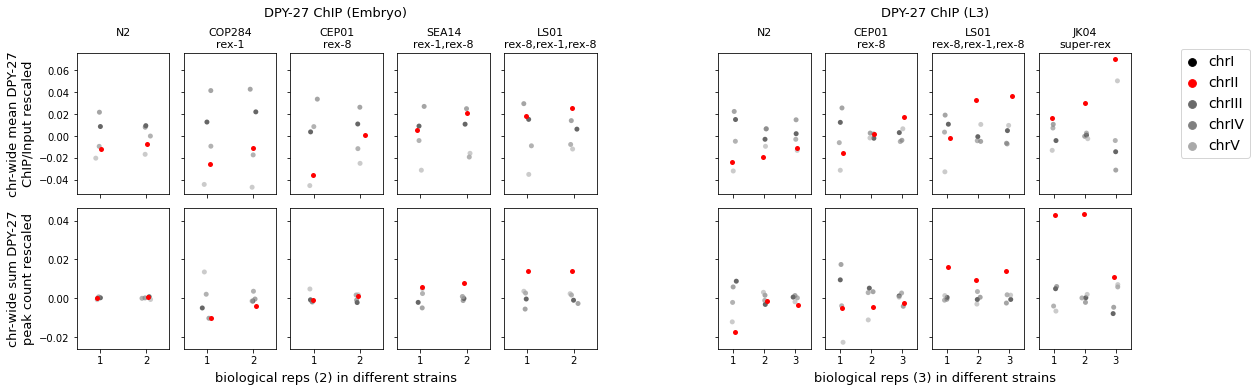

In [203]:
chr_region = 'chr-wide'
emb_cond_ids = ['N2','N2','COP284','COP284','CEP01','CEP01','SEA14','SEA14','LS01','LS01']
L3_cond_ids = ['N2','N2','N2','CEP01','CEP01','CEP01','LS01','LS01','LS01','JK04','JK04','JK04']

dat = [multibigwig_rescale_average(emb_bws_raw,emb_cond_ids,['1','2']*5,chr_region),
       multibigwig_rescale_average(L3_bws_raw,L3_cond_ids,['1','2','3']*4,chr_region)]
dat1 = [multisample_summits_counter(emb_peaks_reps,emb_cond_ids,['1','2']*5),
       multisample_summits_counter(L3_peaks_reps,L3_cond_ids,['1','2','3']*4)]


f, axs = plt.subplots(figsize=(16, 5),
                            nrows=2,
                            ncols=10,
                            sharex='col',sharey='row')

axs[0,5].axis('off')
axs[1,5].axis('off')

# global labeling
sub_titles = ['N2','COP284','CEP01','SEA14','LS01',]
chrom_A = ['chrI','chrIII','chrIV','chrV']
colors_A = ['black','dimgray','grey','darkgrey']
smallFont=12
bigFont=13
d = .01


sub_titles = ["N2\n","COP284\nrex-1","CEP01\nrex-8","SEA14\nrex-1,rex-8","LS01\nrex-8,rex-1,rex-8",
             "",
             "N2\n","CEP01\nrex-8","LS01\nrex-8,rex-1,rex-8","JK04\nsuper-rex"]



emb_conds = ['N2','COP284','CEP01','SEA14','LS01']
conds = emb_conds
for i in range(len(conds)):
    dat_i = dat[0][dat[0]['sample']==conds[i]]
    dat1_i = dat1[0][dat1[0]['sample']==conds[i]]
    sns.stripplot(ax=axs[0,i],data=dat_i[dat_i['chrom'].isin(chrom_A)],
                  x='reps',y='avg_rescaled',hue='chrom',palette=colors_A,alpha=0.6)
    sns.stripplot(ax=axs[0,i],data=dat_i[dat_i['chrom'].isin(['chrII'])],
                  x='reps',y='avg_rescaled',hue='chrom',palette=['red'],alpha=1)
    sns.stripplot(ax=axs[1,i],data=dat1_i[dat1_i['chrom'].isin(chrom_A)],
                  x='reps',y='peaks_rescaled',hue='chrom',palette=colors_A,alpha=0.6)
    sns.stripplot(ax=axs[1,i],data=dat1_i[dat1_i['chrom'].isin(['chrII'])],
                  x='reps',y='peaks_rescaled',hue='chrom',palette=['red'],alpha=1)


L3_conds = ['N2','CEP01','LS01','JK04']
conds = L3_conds
for i in range(len(conds)):
    dat_i = dat[1][dat[1]['sample']==conds[i]]
    dat1_i = dat1[1][dat1[1]['sample']==conds[i]]
    sns.stripplot(ax=axs[0,6+i],data=dat_i[dat_i['chrom'].isin(chrom_A)],
                  x='reps',y='avg_rescaled',hue='chrom',palette=colors_A,alpha=0.6)
    sns.stripplot(ax=axs[0,6+i],data=dat_i[dat_i['chrom'].isin(['chrII'])],
                  x='reps',y='avg_rescaled',hue='chrom',palette=['red'],alpha=1)
    sns.stripplot(ax=axs[1,6+i],data=dat1_i[dat1_i['chrom'].isin(chrom_A)],
                  x='reps',y='peaks_rescaled',hue='chrom',palette=colors_A,alpha=0.6)
    sns.stripplot(ax=axs[1,6+i],data=dat1_i[dat1_i['chrom'].isin(['chrII'])],
                  x='reps',y='peaks_rescaled',hue='chrom',palette=['red'],alpha=1)


    
for i in list(range(5))+list(range(6,10)):
    axs[0,i].set_title(sub_titles[i],fontsize=11)
    for j in range(2):
        axs[j,i].set_ylabel('')
        axs[j,i].set_xlabel('')
        axs[j,i].legend_.remove()
        

    
axs[0,0].set_ylabel('chr-wide mean DPY-27\nChIP/Input rescaled',fontsize=bigFont)
axs[1,0].set_ylabel('chr-wide sum DPY-27\npeak count rescaled',fontsize=bigFont)

f.text(0.3, -0.012, 'biological reps (2) in different strains', ha='center',fontsize=bigFont)
f.text(0.82, -0.012, 'biological reps (3) in different strains', ha='center',fontsize=bigFont)

f.text(0.3, 1, 'DPY-27 ChIP (Embryo)', ha='center',fontsize=bigFont)
f.text(0.82, 1, 'DPY-27 ChIP (L3)', ha='center',fontsize=bigFont)

leg = axs[0,0].get_legend_handles_labels()
reorder=[0,4,1,2,3]
f.legend([list(leg[0])[i] for i in reorder],
         [list(leg[1])[i] for i in reorder],
         bbox_to_anchor=(1.1, 0.93), prop={'size': 14}, handlelength=0.8)


plt.tight_layout()

In [204]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v8/Fig4_chrwide_mean_MACS_rescaled.pdf',dpi=800,bbox_inches='tight')

In [13]:
######################### at rex signal #####################
rexsize = 400
L3_rex = pd.DataFrame([])
for i in range(3):
    a = normalize_to_endogenous([L3_bws_raw[j] for j in [3,4,5]][i],CEP01_annot,strong,rexsize,'CEP01','rep'+str(i+1))
    b = normalize_to_endogenous([L3_bws_raw[j] for j in [6,7,8]][i],LS01_annot,strong,rexsize,'LS01','rep'+str(i+1))
    c = normalize_to_endogenous([L3_bws_raw[j] for j in [9,10,11]][i],JK04_annot,strong,rexsize,'JK04','rep'+str(i+1))
    L3_rex = L3_rex.append(a)
    L3_rex = L3_rex.append(b)
    L3_rex = L3_rex.append(c)
L3_rex.reset_index(drop=True,inplace=True)
    
emb_rex = pd.DataFrame([])
for i in range(2):
    a = normalize_to_endogenous([emb_bws_raw[j] for j in [2,3]][i],COP284_annot,strong,rexsize,'COP284','rep'+str(i+1))
    b = normalize_to_endogenous([emb_bws_raw[j] for j in [4,5]][i],CEP01_annot,strong,rexsize,'CEP01','rep'+str(i+1))
    c = normalize_to_endogenous([emb_bws_raw[j] for j in [6,7]][i],SEA14_annot,strong,rexsize,'SEA14','rep'+str(i+1))
    d = normalize_to_endogenous([emb_bws_raw[j] for j in [8,9]][i],LS01_annot,strong,rexsize,'LS01','rep'+str(i+1))
    emb_rex = emb_rex.append(a)
    emb_rex = emb_rex.append(b)
    emb_rex = emb_rex.append(c)
    emb_rex = emb_rex.append(d)
emb_rex.reset_index(drop=True,inplace=True)

######## organize by rex
emb_rex1 = emb_rex.loc[emb_rex['name'].isin(['rex-1snp'])]
emb_rex1['newlabel'] = emb_rex1['sample']+'_'+emb_rex1['name']


emb_rex8 = emb_rex.loc[emb_rex['name'].isin(['rex-8','rex-8right','rex-8left'])]
emb_rex8['newlabel'] = emb_rex8['sample']+'_'+emb_rex8['name']

L3_rex8 = L3_rex.loc[L3_rex['name'].isin(['rex-8','rex-8right','rex-8left'])]
L3_rex8['newlabel'] = L3_rex8['sample']+'_'+L3_rex8['name']

L3_super = L3_rex.loc[L3_rex['name'].isin(['superRex'])]
L3_super['newlabel'] = L3_super['sample']+'_'+L3_super['name']



<ipython-input-13-a5e227570f25>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emb_rex1['newlabel'] = emb_rex1['sample']+'_'+emb_rex1['name']
<ipython-input-13-a5e227570f25>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emb_rex8['newlabel'] = emb_rex8['sample']+'_'+emb_rex8['name']
<ipython-input-13-a5e227570f25>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [35]:
dat[3]

,chrom,start,end,name,score,strand,raw,ratio,sample,reps,newlabel
4,II,8420106,8421078,superRex,1000,.,6.936426,0.986000,JK04,rep1,JK04_superRex
9,II,8420106,8421078,superRex,1000,.,6.517600,0.995085,JK04,rep2,JK04_superRex
14,II,8420106,8421078,superRex,1000,.,11.816955,1.077318,JK04,rep3,JK04_superRex


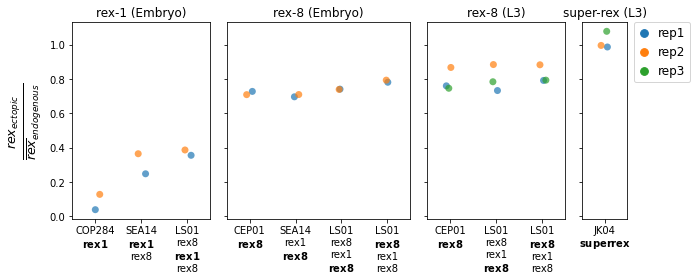

In [207]:
###### plot at rex signal

f, axs = plt.subplots(
    figsize=(9, 4),
    nrows=1,
    ncols=4,
    sharex=False,
    sharey='row',
    gridspec_kw={'width_ratios': [3,4,3,1]}
)

dat = [emb_rex1,emb_rex8,L3_rex8,L3_super]

subtitles = ['rex-1 (Embryo)','rex-8 (Embryo)','rex-8 (L3)','super-rex (L3)']
Alpha=0.7

order0 = ['COP284_rex-1snp','SEA14_rex-1snp','LS01_rex-1snp']
order1 = ['CEP01_rex-8','SEA14_rex-8','LS01_rex-8right','LS01_rex-8left']
order2 = ['CEP01_rex-8','LS01_rex-8right','LS01_rex-8left']
order3 = ['JK04_superRex']
orders_list = [order0,order1,order2,order3]


xticklabels0 = ["COP284"+"\n"+r"$\bf{rex1}$",
                "SEA14"+"\n"+r"$\bf{rex1}$"+"\n"+"rex8",
                "LS01"+"\n"+"rex8"+"\n"+r"$\bf{rex1}$"+"\n"+"rex8"]
xticklabels1 = ["CEP01"+"\n"+r"$\bf{rex8}$",
                "SEA14"+"\n"+"rex1"+"\n"+r"$\bf{rex8}$",
                "LS01"+"\n"+"rex8"+"\n"+"rex1"+"\n"+r"$\bf{rex8}$",
                "LS01"+"\n"+r"$\bf{rex8}$"+"\n"+"rex1"+"\n"+"rex8"]

xticklabels2 = ["CEP01"+"\n"+r"$\bf{rex8}$",
                "LS01"+"\n"+"rex8"+"\n"+"rex1"+"\n"+r"$\bf{rex8}$",
                "LS01"+"\n"+r"$\bf{rex8}$"+"\n"+"rex1"+"\n"+"rex8"]

xticklabels3 = ["JK04"+"\n"+r"$\bf{superrex}$"]

xticklabels = [xticklabels0,xticklabels1,xticklabels2,xticklabels3]

for i in range(len(dat)):
    if i in [0,1,3]:
        ax = sns.stripplot(ax=axs[i],data=dat[i],x='newlabel',y='ratio',hue='reps',alpha=Alpha,order=orders_list[i],s=7)
    else :
        ax = sns.stripplot(ax=axs[i],data=dat[i],x='newlabel',y='ratio',hue='reps',alpha=Alpha,order=orders_list[i],s=7)
    ax.legend_.remove()
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticklabels(xticklabels[i])

    ax.set_title(subtitles[i])
        
        
axs[0].set_ylabel(r"$\frac{rex_{ectopic}}{\overline{rex}_{endogenous}}$" ,
               rotation=90,fontsize=18, labelpad=6)

leg = ax.get_legend_handles_labels()
f.legend(leg[0],leg[1],
         bbox_to_anchor=(1.08, 0.93), prop={'size': 12}, handlelength=0.8)




plt.tight_layout()


In [208]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v8/Fig4_atrex_400bp.pdf',dpi=800,bbox_inches='tight')

8412511
10900000 12500000
16000
8000
16000


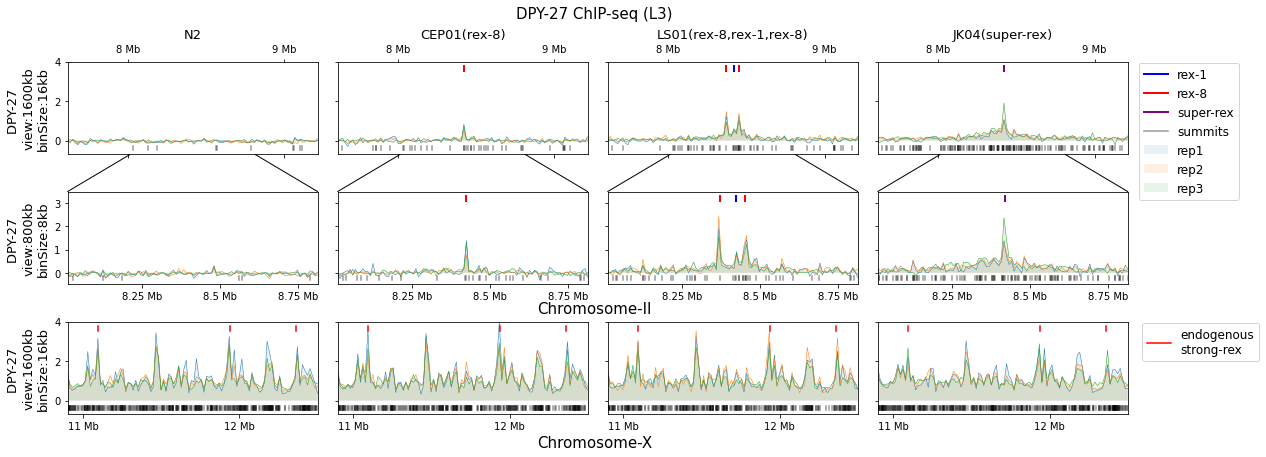

In [191]:
###### plot L3 with X

fig, axs = plt.subplots(
    figsize=(19, 5),
    nrows=3,
    ncols=4,
    sharex=False,
    sharey='row',gridspec_kw={'height_ratios':[1,1,1]}
)

L3_bws
# data grouping
N2 = [L3_bws[0],L3_bws[1],L3_bws[2]]
CEP01 = [L3_bws[3],L3_bws[4],L3_bws[5]]
LS01 = [L3_bws[6],L3_bws[7],L3_bws[8]]
JK04 = [L3_bws[9],L3_bws[10],L3_bws[11]]



dat = [N2,CEP01,LS01,JK04]
reps_label = ['rep1','rep2','rep3']
# layer1: conditions, layer2: reps

dat_peaks = L3_peaks_major
annotations = [CEP01_annot,LS01_annot,JK04_annot]
strains = ['N2', 'CEP01(rex-8)','LS01(rex-8,rex-1,rex-8)','JK04(super-rex)']




########## view range #####
chromo = ['chrII','chrII','chrX']

center=(8371565+8453457)//2
#endoRex = (11093935+11094336)//2
endoRex = 11700000
print(center)
flank = [800000,400000]


views = []
for f in range(len(flank)):
    views.append([center-flank[f],center+flank[f]])
views.append([endoRex-flank[0],endoRex+flank[0]])
print(endoRex-flank[0],endoRex+flank[0])
######### global params ##########
ylims = [[-0.7,4],[-0.5,3.5],[-0.7,4]]
bigFont = 15
smallFont = 13
##################################

for v in range(len(views)):
    views_v = views[v]
    nbins=100
    binSize = int((views_v[1]-views_v[0])//nbins)
    print(binSize)
    for c in range(len(dat)):
        ax = axs[v,c]
        for i in range(len(dat[c])):
            xval = np.linspace(views_v[0],views_v[1],nbins)
            yval = np.array(dat[c][i].stats(chromo[v],views_v[0],views_v[1],type="mean",nBins=nbins),dtype=float)
            mask = np.isfinite(yval)
            ax.plot(
                xval[mask],
                yval[mask],linewidth=0.5)
            ax.fill_between(xval[mask],0,yval[mask],interpolate=False, alpha=0.1,label=reps_label[i])
            ax.set_ylim(ylims[v])
            ax.set_xlim(views_v[0],views_v[1])
        ##### plot peaks
        dat_peaks_c = bed3_mids(dat_peaks[c],chromo[v],views_v[0],views_v[1])
        for p in range(len(dat_peaks_c['mid'])):
            ax.axvline(x=dat_peaks_c['mid'][p],ymin=0.05,ymax=0.09,c="black",alpha=0.4,label='summits')


            
################## connect lines ################
xy0 = (views[1][0],ylims[0][0])
xy1 = (views[1][0],ylims[1][1])
xy2 = (views[1][1],ylims[0][0])
xy3 = (views[1][1],ylims[1][1])

for c in range(len(dat)):
    con01 = ConnectionPatch(xyA=xy1, xyB=xy0,coordsA="data", coordsB="data",
                      axesA=axs[1,c], axesB=axs[0,c], color="black")
    con23 = ConnectionPatch(xyA=xy3, xyB=xy2,coordsA="data", coordsB="data",
                      axesA=axs[1,c], axesB=axs[0,c], color="black")
    axs[1,c].add_artist(con01)
    axs[1,c].add_artist(con23)
    
    ################## axis labeling ###############3
    format_ticks(axs[1,c],y=False,rotate=False)
    format_ticks(axs[0,c],y=False,rotate=False)
    format_ticks(axs[2,c],y=False,rotate=False)
    axs[2,c].locator_params(axis='x',nbins=3,tight=True)
    axs[1,c].locator_params(axis='x',nbins=3,tight=True)
    axs[0,c].tick_params(axis="x", bottom=True, top=True, labelbottom=False, labeltop=True)
    axs[0,c].locator_params(axis='x',nbins=3,tight=True)
    axs[0,c].set_title(strains[c],fontsize=smallFont)
    

    ################## rex label ###############3
    if c > 0:
        annot_c = bed3_mids(annotations[c-1],'II',views[0][0],views[0][1])
        for a in range(len(annot_c)):
            if annot_c['name'][a] in ['rex-1','rex-1snp']:
                axs[0,c].axvline(x=annot_c['mid'][a],ymin=0.90,ymax=0.95,c=rex_colors[0],alpha=1,label='rex-1',lw=2)
                axs[1,c].axvline(x=annot_c['mid'][a],ymin=0.90,ymax=0.95,c=rex_colors[0],alpha=1,label='rex-1',lw=2)

            if annot_c['name'][a] in ['rex-8','rex-8left','rex-8right']:
                axs[0,c].axvline(x=annot_c['mid'][a],ymin=0.90,ymax=0.95,c=rex_colors[1],alpha=1,label='rex-8',lw=2)
                axs[1,c].axvline(x=annot_c['mid'][a],ymin=0.90,ymax=0.95,c=rex_colors[1],alpha=1,label='rex-8',lw=2)
            if annot_c['name'][a] in ['superRex']:
                axs[0,c].axvline(x=annot_c['mid'][a],ymin=0.90,ymax=0.95,c=rex_colors[2],alpha=1,label='super-rex',lw=2)
                axs[1,c].axvline(x=annot_c['mid'][a],ymin=0.90,ymax=0.95,c=rex_colors[2],alpha=1,label='super-rex',lw=2)

    annot_strong = bed3_mids(strong,'X',views[2][0],views[2][1])
    for a in range(len(annot_strong)):
        axs[2,c].axvline(x=annot_strong['mid'][a],ymin=0.90,ymax=0.95,c='red',alpha=1,label='endogenous\nstrong-rex')
                          
handles, labels = [(a + b) for a, b in zip(axs[0,2].get_legend_handles_labels(), axs[0,3].get_legend_handles_labels())]
by_label = dict(zip(labels, handles))
reorder = [2,1,6,0,3,4,5]

axs[0,3].legend([list(by_label.values())[i] for i in reorder], [list(by_label.keys())[i] for i in reorder],
                bbox_to_anchor=(1.02, 1.05),prop={'size': 12})

handles, labels = axs[2,3].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs[2,3].legend([list(by_label.values())[1]],[list(by_label.keys())[1]],bbox_to_anchor=(1.55, 1.05),prop={'size': 12})
                

for v in range(len(views)):
    axs[v,0].set_ylabel('DPY-27 \nview:'+str(int(views[v][1]-views[v][0])//1000)+'kb'+ 
                        '\nbinSize:'+str(int(views[v][1]-views[v][0])//1000//nbins)+'kb',fontsize=smallFont)



fig.text(0.51, 0.29, 'Chromosome-II', ha='center',fontsize=bigFont)
fig.text(0.51, -0.08, 'Chromosome-X', ha='center',fontsize=bigFont)

fig.text(0.51, 1.11, 'DPY-27 ChIP-seq (L3)', ha='center',fontsize=bigFont)

plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.08)

#plt.tight_layout()


In [192]:
fig.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v8/Fig4_snapshot_L3.pdf',dpi=800,bbox_inches='tight')

8412511
10900000 12500000
16000
8000
16000


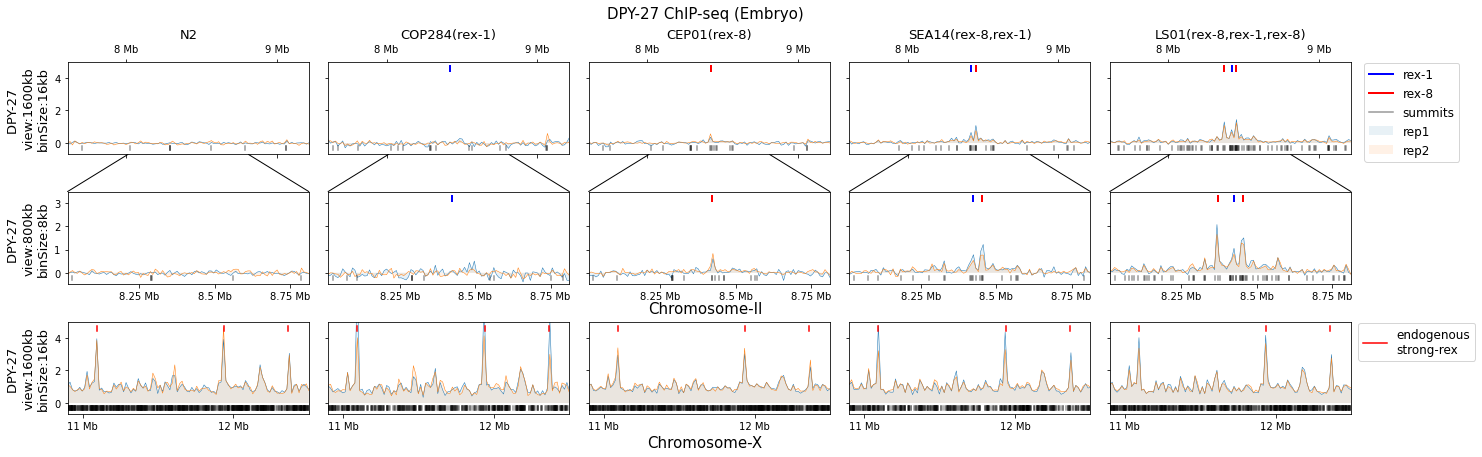

In [189]:
###### plot emb with X

fig, axs = plt.subplots(
    figsize=(23, 5),
    nrows=3,
    ncols=5,
    sharex=False,
    sharey='row',gridspec_kw={'height_ratios':[1,1,1]}
)

emb_bws
# data grouping


N2 = [emb_bws[0],emb_bws[1]]
COP284 = [emb_bws[2],emb_bws[3]]
CEP01 = [emb_bws[4],emb_bws[5]]
SEA14 = [emb_bws[6],emb_bws[7]]
LS01 = [emb_bws[8],emb_bws[9]]





dat = [N2,COP284,CEP01,SEA14,LS01]
reps_label = ['rep1','rep2']
annotations = [COP284_annot,CEP01_annot,SEA14_annot,LS01_annot,JK04_annot]
strains = ['N2','COP284(rex-1)', 'CEP01(rex-8)','SEA14(rex-8,rex-1)','LS01(rex-8,rex-1,rex-8)']

# layer1: conditions, layer2: reps


dat_peaks = emb_peaks_combined






########## view range #####
chromo = ['chrII','chrII','chrX']

center=(8371565+8453457)//2
#endoRex = (11093935+11094336)//2
endoRex = 11700000
print(center)
flank = [800000,400000]


views = []
for f in range(len(flank)):
    views.append([center-flank[f],center+flank[f]])
views.append([endoRex-flank[0],endoRex+flank[0]])
print(endoRex-flank[0],endoRex+flank[0])
######### global params ##########
ylims = [[-0.7,5],[-0.5,3.5],[-0.7,5]]
bigFont = 15
smallFont = 13
##################################

for v in range(len(views)):
    views_v = views[v]
    nbins=100
    binSize = int((views_v[1]-views_v[0])//nbins)
    print(binSize)
    for c in range(len(dat)):
        ax = axs[v,c]
        for i in range(len(dat[c])):
            xval = np.linspace(views_v[0],views_v[1],nbins)
            yval = np.array(dat[c][i].stats(chromo[v],views_v[0],views_v[1],type="mean",nBins=nbins),dtype=float)
            mask = np.isfinite(yval)
            ax.plot(
                xval[mask],
                yval[mask],linewidth=0.5)
            ax.fill_between(xval[mask],0,yval[mask],interpolate=False, alpha=0.1,label=reps_label[i])
            ax.set_ylim(ylims[v])
            ax.set_xlim(views_v[0],views_v[1])
        ##### plot peaks
        dat_peaks_c = bed3_mids(dat_peaks[c],chromo[v],views_v[0],views_v[1])
        for p in range(len(dat_peaks_c['mid'])):
            ax.axvline(x=dat_peaks_c['mid'][p],ymin=0.05,ymax=0.09,c="black",alpha=0.4,label='summits')


            
################## connect lines ################
xy0 = (views[1][0],ylims[0][0])
xy1 = (views[1][0],ylims[1][1])
xy2 = (views[1][1],ylims[0][0])
xy3 = (views[1][1],ylims[1][1])

for c in range(len(dat)):
    con01 = ConnectionPatch(xyA=xy1, xyB=xy0,coordsA="data", coordsB="data",
                      axesA=axs[1,c], axesB=axs[0,c], color="black")
    con23 = ConnectionPatch(xyA=xy3, xyB=xy2,coordsA="data", coordsB="data",
                      axesA=axs[1,c], axesB=axs[0,c], color="black")
    axs[1,c].add_artist(con01)
    axs[1,c].add_artist(con23)
    
    ################## axis labeling ###############3
    format_ticks(axs[1,c],y=False,rotate=False)
    format_ticks(axs[0,c],y=False,rotate=False)
    format_ticks(axs[2,c],y=False,rotate=False)
    axs[2,c].locator_params(axis='x',nbins=3,tight=True)
    axs[1,c].locator_params(axis='x',nbins=3,tight=True)
    axs[0,c].tick_params(axis="x", bottom=True, top=True, labelbottom=False, labeltop=True)
    axs[0,c].locator_params(axis='x',nbins=3,tight=True)
    axs[0,c].set_title(strains[c],fontsize=smallFont)
    

    ################## rex label ###############3
    if c > 0:
        annot_c = bed3_mids(annotations[c-1],'II',views[0][0],views[0][1])
        for a in range(len(annot_c)):
            if annot_c['name'][a] in ['rex-1','rex-1snp']:
                axs[0,c].axvline(x=annot_c['mid'][a],ymin=0.90,ymax=0.95,c=rex_colors[0],alpha=1,label='rex-1',lw=2)
                axs[1,c].axvline(x=annot_c['mid'][a],ymin=0.90,ymax=0.95,c=rex_colors[0],alpha=1,label='rex-1',lw=2)

            if annot_c['name'][a] in ['rex-8','rex-8left','rex-8right']:
                axs[0,c].axvline(x=annot_c['mid'][a],ymin=0.90,ymax=0.95,c=rex_colors[1],alpha=1,label='rex-8',lw=2)
                axs[1,c].axvline(x=annot_c['mid'][a],ymin=0.90,ymax=0.95,c=rex_colors[1],alpha=1,label='rex-8',lw=2)
            if annot_c['name'][a] in ['superRex']:
                axs[0,c].axvline(x=annot_c['mid'][a],ymin=0.90,ymax=0.95,c=rex_colors[2],alpha=1,label='super-rex',lw=2)
                axs[1,c].axvline(x=annot_c['mid'][a],ymin=0.90,ymax=0.95,c=rex_colors[2],alpha=1,label='super-rex',lw=2)

    annot_strong = bed3_mids(strong,'X',views[2][0],views[2][1])
    for a in range(len(annot_strong)):
        axs[2,c].axvline(x=annot_strong['mid'][a],ymin=0.90,ymax=0.95,c='red',alpha=1,label='endogenous\nstrong-rex')
                          
handles, labels = [(a + b) for a, b in zip(axs[0,2].get_legend_handles_labels(), axs[0,3].get_legend_handles_labels())]
by_label = dict(zip(labels, handles))

reorder = [4,1,0,2,3]
axs[0,4].legend([list(by_label.values())[i] for i in reorder], [list(by_label.keys())[i] for i in reorder],
                bbox_to_anchor=(1.03, 1.05),prop={'size': 12})



handles, labels = axs[2,3].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs[2,4].legend([list(by_label.values())[1]],[list(by_label.keys())[1]],bbox_to_anchor=(1.54, 1.05),prop={'size': 12})
                

for v in range(len(views)):
    axs[v,0].set_ylabel('DPY-27 \nview:'+str(int(views[v][1]-views[v][0])//1000)+'kb'+ 
                        '\nbinSize:'+str(int(views[v][1]-views[v][0])//1000//nbins)+'kb',fontsize=smallFont)



fig.text(0.51, 0.29, 'Chromosome-II', ha='center',fontsize=bigFont)
fig.text(0.51, -0.08, 'Chromosome-X', ha='center',fontsize=bigFont)

fig.text(0.51, 1.11, 'DPY-27 ChIP-seq (Embryo)', ha='center',fontsize=bigFont)


plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.08)

In [190]:
fig.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v8/Fig4_snapshot_emb.pdf',dpi=800,bbox_inches='tight')